In [121]:
%matplotlib inline
#The libraries we are going to use are PySerial and Time
# PySerial is encapsulates the access for the serial port.
import serial
import time
import os
import matplotlib.pyplot as plt

In [122]:
# Opening a Serial port

# - The port is immediately opened on object creation, when a port is given. It is not opened when
# port is None and a successive call to open() is required. port is a device name: depending on 
# operating system. e.g. /dev/ttyUSB0 on GNU/Linux or COM3 on Windows.
# - The parameter baudrate can be one of the standard values:  50, 75, 110, 134, 150, 200, 300, 600, 1200,
# 1800, 2400, 4800, 9600, 19200, 38400, 57600, 115200. These are well supported on all platforms.
# - Standard values above 115200, such as:  230400, 460800, 500000, 576000, 921600, 1000000, 1152000,
# 1500000, 2000000, 2500000, 3000000, 3500000, 4000000 also work on many platforms and devices.
# Non-standard values are also supported on some platforms (GNU/Linux, MAC OSX >= Tiger, Windows).
# - Possible values for the parameter timeout which controls the behavior of read():
# .. timeout = None: wait forever until requested number of bytes are received
# .. timeout = 0:  non-blocking mode, return immediately in any case, returning zero or more, up to
# the requested number of bytes
# .. timeout = x:  set timeout to x seconds (float allowed) returns immediately when the requested
# number of bytes are available, otherwise wait until the timeout expires and return all bytes that were
# received until then.
DEMOQE_read = serial.Serial('/dev/ttyUSB0',115200);
print(DEMOQE_read.isOpen())

True


In [123]:
# VARIABLES para almacenar los valores de los sensores en el tiempo
#digital_1 = []
#digital_2 = []
signal = {'analogico_1': [],'analogico_2': [],'digital_1': [],'digital_2': []}
#analogico_1 = []
signal["analogico_1"].append(0)
signal["analogico_1"].append(0)
#analogico_2 = []
# Constantes de manipulacion para el main
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []
i = 0
j = 0
data_list = []
#os.remove("Generator_data.txt")
file = open("Generator_data.txt","w")
file.write("0")
file.close()

In [124]:
#Hex to binary
def dec_to_bin(dec):
    dec_str = str(int(dec))
    cod_bin = bin(int(dec_str))
    return cod_bin

In [125]:
#Binary to decimal
def bin_to_dec(bina):
    cod_dec = int(str(bina),2)
    return cod_dec

In [126]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 D1 D2 A11 A10 A9 A8 A7
def decode_channel1_one(number):
    #decode Channel one
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    digital_one = part_one_bin_comp[1]
    digital_two = part_one_bin_comp[2]
    analogic_most_significant = part_one_bin_comp[3:]
    return digital_one,digital_two,str(analogic_most_significant)

In [127]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 A6 A5 A4 A3 A2 A1 A0
def decode_channel12_two(number):
    #decode channe one and two for less significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_less_significant = part_one_bin_comp[1:]
    return str(analogic_less_significant)

In [128]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 0 0 A11 A10 A9 A8 A7
def decode_channel2_one(number):
    # decode channel two for most significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_most_significant = part_one_bin_comp[3:]
    
    return str(analogic_most_significant)

In [129]:
# We need to concatened the entirely analogic information.
def concatenation(string1,string2):
    return bin_to_dec(int(string1 + str(string2)))

In [130]:
def stream(flag_encabezado = 0):
    #file = open("Generator_data.txt","a")
    
    DEMOQE_read.flush()
    data_input_2 = DEMOQE_read.read(5)
    while True:
        enc_posi = data_input_2.find(245)
        if enc_posi!=0:
            data_input_2 = data_input_2[enc_posi:]
            data_input_3 = DEMOQE_read.read(enc_posi)
            data_input = data_input_2 + data_input_3
        else:
            data_input = data_input_2

        for datop in data_input_2:
            if datop==245:
                flag_encabezado+=1
        if flag_encabezado>1:
            flag_encabezado=0
            data_input_2 =  b'\x00' + data_input_2[1:]
        else:
            break
    
    data_list.append(data_input)
    posic_data_input = len(data_list)-1
    #data_input = data_list[posic_data_input]

    #Codigo 
    list_pos_trama = []
    enc_posi = data_input.find(245)
    
    # Chequeo de encabezado en la primera casilla
    if enc_posi==0:
        flag_first_run=0
    # Longitud de la trama
    trama_length = len(data_input)
    if trama_length!=5:
        pass
    # Cantidad de posiciones de los dos canales, deberia ser 4 siempre
    posiciones = trama_length - enc_posi -1
    # Tomo las posiciones
    for pos in range(posiciones):
        list_pos_trama.append(enc_posi +pos+1)
    for pos_dato_trama in list_pos_trama:
        # Se analiza el CH1 trama[1]
        if (pos_dato_trama == enc_posi +1):
            # Se decodifica y se transforman los bits en significado analogico y digital
            digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
            # Se agregan a sus respectivas listas dentro del diccionario
            signal["digital_1"].append(digital_one)
            signal["digital_2"].append(digital_two)
            auxiliar = analogic_m_b
         # Se analiza el CH1 trama[2]
        elif (pos_dato_trama == enc_posi + 2):
            # Se decodifica y se transforman los bits en significado analogico
            analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
            # se concatena para obtener toda la informacion del analogico
            signal["analogico_1"].append(concatenation(auxiliar,analogic_l_b))
        # Se analiza el CH2 trama[3]
        elif (pos_dato_trama == enc_posi + 3):
            # Se decodifica y se transforman los bits en significado analogico y digital
            analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
            auxiliar2 = analogic_m_b
        # Se analiza el CH2 trama[4]
        elif (pos_dato_trama == enc_posi + 4):
            # Se decodifica y se transforman los bits en significado analogico
            analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
            # se concatena para obtener toda la informacion del analogico
            signal["analogico_2"].append(concatenation(auxiliar2,analogic_l_b))
        else:
            print("Encabezado fuera de posicion, peligro!!")
            break
  
    #file.write(str(analogico_1[len(analogico_1)-1])+"\n")

In [131]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def nothing():
    pass 

class Scope(object):
    def __init__(self, ax, maxt=0.5, dt=0.001):
        self.ax = ax
        self.dt = dt
        self.maxt = maxt
        self.tdata = [0]
        self.ydata = [0]
        self.line = Line2D(self.tdata, self.ydata)
        self.ax.add_line(self.line)
        self.ax.set_ylim(0, 2)
        self.ax.set_xlim(0, self.maxt)
        self.len_ana1_aux = 1
        self.Amplitude = 1
    def update(self, i):
        lastt = self.tdata[-1]
        datos_analogico_1 = signal["analogico_1"]
        #print(datos_analogico_1)
        self.len_ana1_aux = len(datos_analogico_1)
        file2 = open("time_base_data.txt","r")
        t2_read = float(file2.read())
        file3 = open("amplitud_data.txt","r")
        self.Amplitude = float(file3.read())
        self.maxt = t2_read
        self.ax.set_xlim(self.tdata[0], self.tdata[0] + self.maxt)
        if lastt > self.tdata[0] + self.maxt:  # reset the arrays
            self.tdata = [self.tdata[-1]]
            self.ydata = [self.ydata[-1]]
            self.ax.set_xlim(self.tdata[0], self.tdata[0] + self.maxt)
            self.ax.figure.canvas.draw()
        t = self.tdata[-1] + self.dt
        self.tdata.append(t)
        y = (float(datos_analogico_1[i-1])*3/4095)*self.Amplitude
        self.ydata.append(y)
        print(self.ydata)
        self.ax.set_ylim(0, 2)
        self.line.set_data(self.tdata, self.ydata)
        signal["analogico_1"] = []
        file.close()
        file2.close()
        return self.line,

def emitter():
    i = 0
    while i <= scope.len_ana1_aux:
        i += 1
        yield i

[0, 0.0]


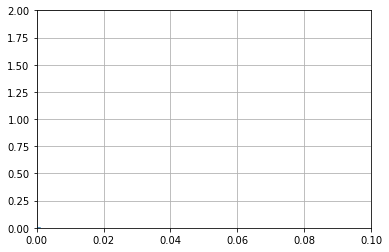

[0, 0.3304029304029304]


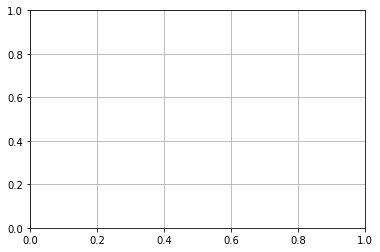

[0, 1.2175824175824175]


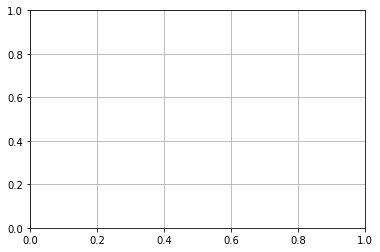

[0, 0.18754578754578755]


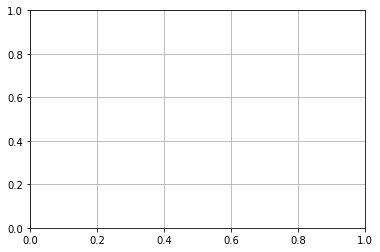

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/usr/local/lib/python3.5/dist-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.5/dist-packages/matplotlib/animation.py", line 1772, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-131-0cf19a22171a>", line 39, in update
    y = (float(datos_analogico_1[i-1])*3/4095)*self.Amplitude
IndexError: list index out of range


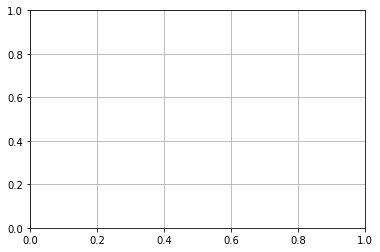

[0, 1.1505494505494505]


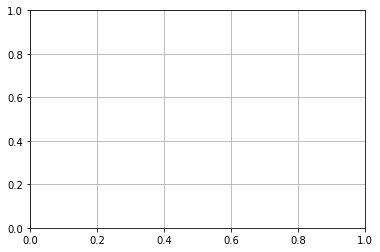

[0, 0.2600732600732601]


KeyboardInterrupt: 

In [132]:
fig, ax = plt.subplots()
while True:
    DEMOQE_read = serial.Serial('/dev/ttyUSB0',115200);
    scope = Scope(ax)
    ani = animation.FuncAnimation(fig, scope.update,emitter,interval=10,blit=True)
    stream()
    plt.grid()
    plt.draw()
    plt.show(block = False)
    DEMOQE_read.close()

# AQUI esta el codigo viejo just in case

In [ ]:
flag_first_run = 0
flag_encabezado = 0
def stream():
    file = open("Generator_data.txt","a")
    while (DEMOQE_read.inWaiting()==0):
        pass
            # Se recibiran 5 bytes por el puerto serial segun el protocolo
            # time.sleep(0.000001)
    
    DEMOQE_read.flush()
    data_input_2 = DEMOQE_read.read(5)
    while True:
        enc_posi = data_input_2.find(245)
        if enc_posi!=0:
            data_input_2 = data_input_2[enc_posi:]
            data_input_3 = DEMOQE_read.read(enc_posi)
            data_input = data_input_2 + data_input_3
        else:
            data_input = data_input_2

        for datop in data_input_2:
            if datop==245:
                flag_encabezado+=1
        if flag_encabezado>1:
            flag_encabezado=0
            data_input_2 =  b'\x00' + data_input_2[1:]
        else:
            break
    
    data_list.append(data_input)
    
    posic_data_input = len(data_list)-1
    #data_input = data_list[posic_data_input]

    #Codigo 
    flag_trama_len_cst = 0
    list_pos_trama = []
    
    enc_posi = data_input.find(245)
    
    # Chequeo de encabezado en la primera casilla
    if enc_posi==0:
        flag_first_run=0
    # Longitud de la trama
    trama_length = len(data_input)
    if trama_length!=5:
        pass
    posiciones = trama_length - enc_posi -1
    # Chequeo de encabezado en su ultima casilla
    if posiciones==0:
        flag_first_run=1
    # Entrando formato de la primera corrida
    if (flag_first_run==0):
        for pos in range(posiciones):
            list_pos_trama.append(enc_posi +pos+1)
        for pos_dato_trama in list_pos_trama:
            if (pos_dato_trama == enc_posi +1):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 2):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==2:
                    flag_trama_len_cst=0
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi + 3):
                
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
                if enc_posi==1:
                    flag_trama_len_cst=0
                    flag_first_run=1
                    analogic_l_b = decode_channel12_two(data_input[0])
                    analogico_2.append(concatenation(auxiliar2,analogic_l_b))
            elif (pos_dato_trama == enc_posi + 4):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
            else:
                flag_first_run=1
                if (flag_trama_len_cst == 4):
                    flag_trama_len_cst = 0
                    flag_first_run=0
    else:
        posiciones = trama_length - enc_posi -1
        # Verificar que llegaron los dos canales completos
        for pos_dato_trama in range(enc_posi):
            if (pos_dato_trama == enc_posi -1):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==1:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[2])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[3])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    analogic_m_b = decode_channel2_one(data_input[4])
                    auxiliar2 = analogic_m_b
                    flag_first_run=1
                if enc_posi==2:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[3])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[4])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi -2):
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -3):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -4):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            else:
                flag_trama_len_cst = 0
                flag_first_run = 0
    
    if analogico_1[len(analogico_1)-1]>=4095:
        print (auxiliar, analogic_l_b, analogico_1, data_list[len(data_list)-3],data_list[len(data_list)-2],data_list[len(data_list)-1])
        break
    file.write(str(analogico_1[len(analogico_1)-1])+"\n")